In [3]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os

In [4]:
os.chdir("./MIA-TESIS/GAN")

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTiuTO77FKnu7S-WAnOFYYW6PI-M2xh8lKs8w&s)

![](https://neuropsychology.github.io/NeuroKit/_images/3D.png)

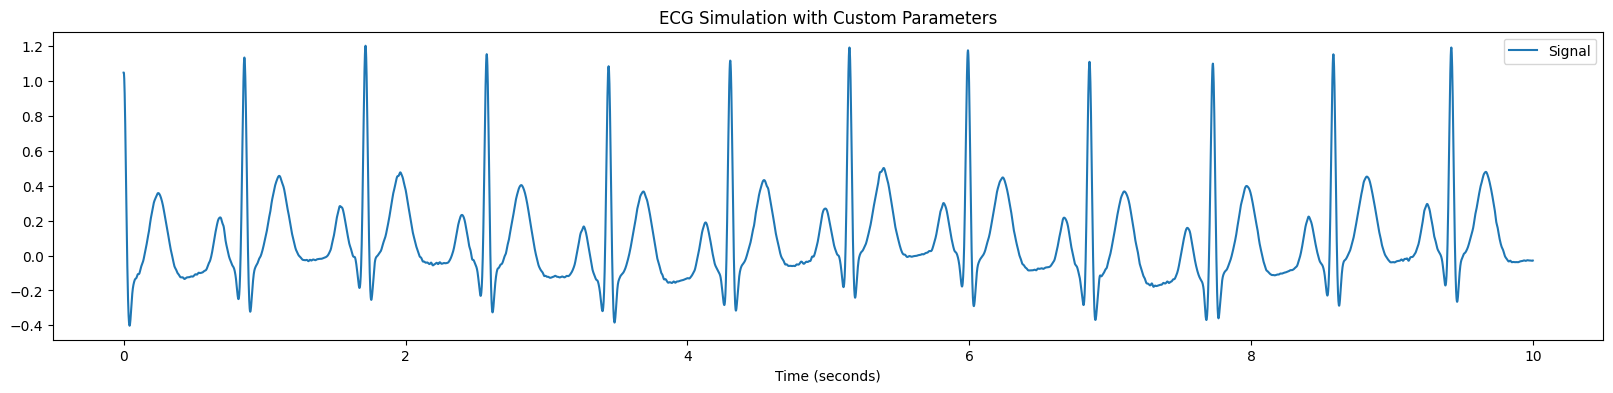

In [5]:
fs =1000  # Sampling frequency

# Normal parameters (used by default)
# ===================================
# t, the starting position along the circle of each interval in radius
ti = np.array((-70, -15, 0, 15, 100))
# a, the amplitude of each spike
ai = np.array((1.2, -5, 30, -7.5, 0.75))
# b, the width of each spike
bi = np.array((0.25, 0.1, 0.1, 0.1, 0.4))

# Add small noise
# ===============
ti = np.random.normal(ti, np.ones(5) * 0.2)  # Much less noise
ai = np.random.normal(ai, np.abs(ai / 20))   # Much less noise
bi = np.random.normal(bi, np.abs(bi / 20))   # Much less noise

ecg12 = nk.ecg_simulate(duration=10, method="ecgsym", ti=ti, ai=ai, bi=bi, fs=fs)

# Visualize results
#plt.figure(figsize=(20, 4))
nk.signal_plot(ecg12, sampling_rate=1000, title="ECG Simulation with Custom Parameters", figsize=(20, 4))


In [6]:
# Generar una base de datos de señales ECG simuladas

num_samples = 100  # Número de señales a generar
ecg_db = []

for _ in range(num_samples):
    # Variar ligeramente los parámetros para cada señal
    ti_sample = np.random.normal(ti, np.ones(5) * 0.2)
    ai_sample = np.random.normal(ai, np.abs(ai / 20))
    bi_sample = np.random.normal(bi, np.abs(bi / 20))
    ecg_sample = nk.ecg_simulate(duration=10, method="ecgsym", ti=ti_sample, ai=ai_sample, bi=bi_sample, fs=fs)
    ecg_db.append(ecg_sample)

ecg_db = np.array(ecg_db)  # Shape: (num_samples, len(ecg12))
print(f"Base de datos generada con forma: {ecg_db.shape}")

Base de datos generada con forma: (100, 10000)


In [7]:
ecg_db

array([[ 1.1229273 ,  1.12022549,  1.11157271, ..., -0.02127907,
        -0.02042011, -0.01983449],
       [ 1.02016485,  1.02157902,  1.01785379, ..., -0.03436167,
        -0.03403023, -0.03373554],
       [ 1.00901358,  1.00913304,  1.00378733, ..., -0.00664876,
        -0.00613966, -0.00553455],
       ...,
       [ 0.87590891,  0.87903652,  0.87777938, ...,  0.113632  ,
         0.11472542,  0.11557726],
       [ 1.0198    ,  1.02220656,  1.0188918 , ...,  0.02453848,
         0.02499298,  0.02525831],
       [ 1.1426338 ,  1.1413347 ,  1.13488135, ...,  0.22247923,
         0.22337274,  0.22378088]])

In [9]:
!pwd

/workspace/MIA-TESIS/GAN


In [10]:
!ls

 GEN_EKG.ipynb	        basic2.ipynb		 df_dataset.csv
 basic1.ipynb	       'basic_EKG1 copy.ipynb'	 ecg_db.npy
'basic2 copy 2.ipynb'   basic_EKG1.ipynb	 physionet.org
'basic2 copy.ipynb'     basic_GAN.ipynb


In [11]:
# Exportar la base de datos ecg_db a un archivo .npy
np.save('ekg_db.npy', ecg_db)
print("Base de datos ecg_db exportada como 'ekg_db.npy'")

Base de datos ecg_db exportada como 'ekg_db.npy'


### Carga de datasets

In [12]:
ekg_db_importada = np.load('ekg_db.npy')
print(f"Base de datos importada con forma: {ekg_db_importada.shape}")

Base de datos importada con forma: (100, 10000)


In [19]:
fs

1000

In [32]:
ekg_db_importada.shape

(100, 10000)

Text(0.5, 1.0, 'Primer ejemplo de la base de datos importada')

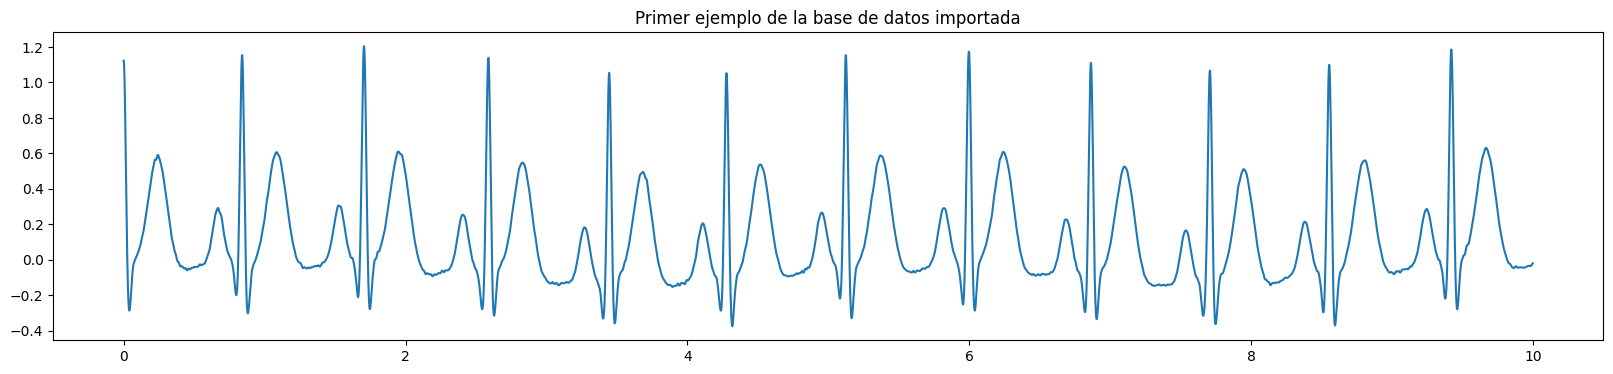

In [18]:
t = np.arange(0, len(ekg_db_importada[0])) / fs  # Tiempo en segundos
plt.figure(figsize=(20, 4))

plt.plot(t, ekg_db_importada[0])
plt.title("Primer ejemplo de la base de datos importada")

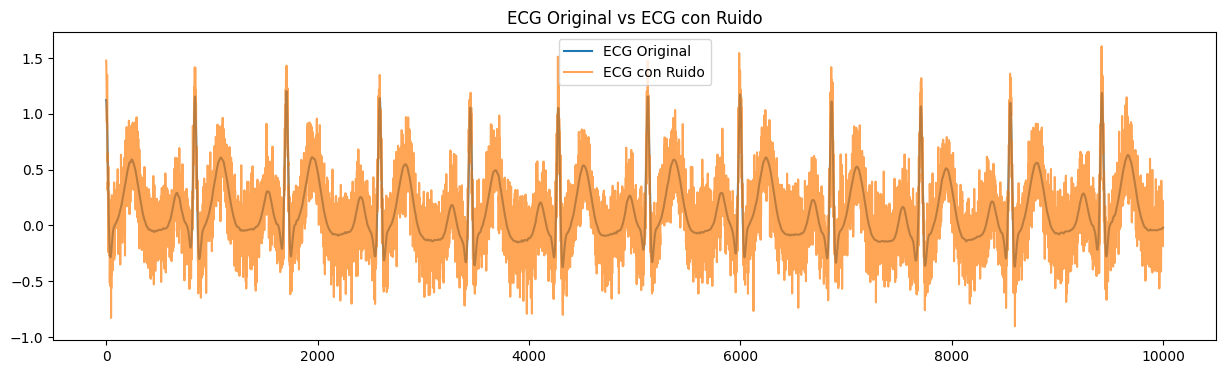

In [23]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Agregar ruido gaussiano a la señal ECG
ecg_noisy = ekg_db_importada[0] + np.random.normal(0, 0.2, size=ekg_db_importada[0].shape)

plt.figure(figsize=(15, 4))
plt.plot(ekg_db_importada[0], label='ECG Original')
plt.plot(ecg_noisy, label='ECG con Ruido', alpha=0.7)
plt.legend()
plt.title("ECG Original vs ECG con Ruido")
plt.show()



### USo de torch para generar las señales

In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
seq_len = 10000 #256
latent_dim = 100
batch_size = 64
epochs = 50
lr = 0.0002

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [39]:
# Simula tus datos reales (reemplaza esto con tus ECG reales)
# real_data = np.sin(np.linspace(0, 3 * np.pi, seq_len))  # forma de onda de ejemplo
# real_data = np.tile(real_data, (1000, 1)) + 0.1 * np.random.randn(1000, seq_len)
# real_data = np.clip(real_data, -1, 1)
real_data = ekg_db_importada.copy()

real_data = torch.tensor(real_data, dtype=torch.float32).to(device)
#real_data = real_data.view(-1, seq_len, 1)  # Forma: (batch_size, seq_len, 1)
# Definir el modelo GAN
real_data

tensor([[ 1.1229,  1.1202,  1.1116,  ..., -0.0213, -0.0204, -0.0198],
        [ 1.0202,  1.0216,  1.0179,  ..., -0.0344, -0.0340, -0.0337],
        [ 1.0090,  1.0091,  1.0038,  ..., -0.0066, -0.0061, -0.0055],
        ...,
        [ 0.8759,  0.8790,  0.8778,  ...,  0.1136,  0.1147,  0.1156],
        [ 1.0198,  1.0222,  1.0189,  ...,  0.0245,  0.0250,  0.0253],
        [ 1.1426,  1.1413,  1.1349,  ...,  0.2225,  0.2234,  0.2238]],
       device='cuda:0')

In [40]:
# Dataset
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

dataset = ECGDataset(real_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generador
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, seq_len),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_len, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

/tmp/ipykernel_832751/647806666.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)


In [41]:
# Inicialización
G = Generator().to(device)
D = Discriminator().to(device)
loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)

In [ ]:
# Entrenamiento
from tqdm import tqdm  # Para mostrar barra de progreso

# Normalizar los datos reales al rango [-1, 1]
real_data = (real_data - real_data.min()) / (real_data.max() - real_data.min())  # Escalar a [0, 1]
real_data = 2 * real_data - 1  # Escalar a [-1, 1]

epochs = 100

for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    
    for real_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_batch = real_batch.to(device)

        # Train Discriminator
        z = torch.randn(real_batch.size(0), latent_dim).to(device)  # Latent vector
        fake_batch = G(z)

        real_labels = torch.ones(real_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())
        D_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = G(z)
        D_fake = D(fake_batch)
        G_loss = loss_fn(D_fake, real_labels)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        # Acumular pérdidas
        epoch_d_loss += D_loss.item()
        epoch_g_loss += G_loss.item()

    # Promediar las pérdidas por época
    epoch_d_loss /= len(dataloader)
    epoch_g_loss /= len(dataloader)

    print(f"Epoch {epoch+1}/{epochs} | D_loss: {epoch_d_loss:.4f} | G_loss: {epoch_g_loss:.4f}")

    # Visualización ocasional
    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        with torch.no_grad():
            sample = G(torch.randn(1, latent_dim).to(device)).cpu().numpy().flatten()
            plt.figure(figsize=(15, 4))
            plt.plot(sample)
            plt.title(f"ECG Sintético - Epoch {epoch+1}")
            plt.grid()
            plt.show()